# **Mobile Money Fraud Detection with Ensemble Machine Learning**
* **Author:** *Stephen Adarkwah*
* **Author Date:** *20240801*
* **Version:** *1.0*
  
### Context
Mobile money fraud detection using machine learning is critical in safeguarding financial ecosystems. It involves applying advanced algorithms and data analysis techniques to identify suspicious activities and prevent real-time fraudulent transactions. An effective fraud detection system should be able to detect fraudulent transactions with high accuracy and efficiency. While avoiding bad actors from executing fraudulent transactions is necessary, ensuring genuine users can access the payment system is also critical. However, many false positives may lead to a poor customer experience, potentially driving customers to take their business elsewhere and highlighting the need for accurate fraud detection.

### Other Challenges 
 A significant challenge in building fraud detection models in research is the availability of transactional datasets due to confidentiality and data governance policies around financial data. Another major challenge in applying Machine Learning to fraud detection is the presence of highly imbalanced data sets. In many available datasets, most transactions are genuine, with a tiny percentage of fraudulent transactions. Designing an accurate and efficient fraud detection system that is low on false positives but detects fraudulent activity effectively is a significant challenge for researchers. 
 
### About Dataset 
The lack of legitimate datasets in mobile money transactions to perform fraud detection research has always been a big problem. This will leave researchers with the burden of harnessing the datasets before conducting the research. Paysim is a financial simulator that simulates mobile money transactions based on an original dataset.

PaySim is based on a sample of genuine mobile money transactions from an African country provided by a multinational company with services in over 14 countries. This synthetic approach offers a valuable resource for advancing fraud detection research. Clone PaySim source repository at https://github.com/EdgarLopezPhD/PaySim/tree/master which is a java based application.

*These fields form the basis of the synthetic dataset, providing a comprehensive view of transaction activities while offering opportunities to study and test fraud detection methods.*


### Research Goals
1. Are there limitations in using ensemble learning to combat modern-day Mobile Money fraud?
2. Can these limitations be fixed or improved?
3. Is ensemble learning an effective combatant against mobile money fraud in contrast to traditional solutions like data mining, anonymous tip lines (including online or website) and financial auditing?



#### Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")


#### Get simulated data

In [3]:
# Loading datasets
df = pd.read_csv('./outputs/paysim.csv')

# fix column names to camel case
dataset = df.rename(columns={'oldbalanceOrg':'oldBalanceOrg', 'newbalanceOrig':'newBalanceOrig',
                             'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
dataset.head()

,step,type,amount,nameOrig,oldBalanceOrg,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# check schema
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrg   float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB



The dataset contains the following attributes:

* **step:** This is a unit of time representing one hour in the real world. The total number of steps is 744, corresponding to a 30-day simulation.

* **type:** The type of transaction performed. The possible types are *CASH-IN*, *CASH-OUT*, *DEBIT*, *PAYMENT*, and *TRANSFER*.

#### About type of transactions
* CASH-IN: Refers to depositing cash into an account (adding funds).

* CASH-OUT: Refers to withdrawing cash from an account (removing funds).

* DEBIT: It refer to a decrease in the balance of a financial account due to a withdrawal or an expense.

* PAYMENT: Refers to the transfer of money from one party (payer) to another (payee) in exchange for goods, services, or as settlement of a debt.

* TRANSFER: Refers to moving money from one account to another, often between accounts held by the same person or entity.


* **amount:** The transaction amount in your preferred local currency (£ in my case).

* **nameOrig:** The customer who initiated the transaction.

* **oldBalanceOrig:** The initial balance of the customer before the transaction.

* **newBalanceOrig:** The new balance of the customer after the transaction.

* **nameDest:** The recipient of the transaction.

* **oldBalanceDest:** The initial balance of the recipient before the transaction. There is no information for customers whose names start with "M" (merchants).

* **newBalanceDest:** The new balance of the recipient after the transaction. As with "oldbalanceDest," there is no information for customers whose names start with "M." (merchants)

* **isFraud:** Indicates whether a transaction is fraudulent.

* **isFlaggedFraud:** Flags transactions that exceed a certain threshold. In this dataset, transfers over 200,000 in a single transaction are flagged as potentially fraudulent.




I get the summarized overview of the dataset to observe the distribution/dispersion in data points.

In [5]:
# get statistics
dataset.describe()

,step,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


The dataset has 6362620 transactions. The mean fraud is 0.00129, which means there are very few fraud cases recorded, i.e., 13 real fraud cases every 10,000 transactions. However, the system successfully detects only 0.025 fraudulent transactions per 10,000 transactions. This proves why we need excellent/advanced mechanisms to help detect fraud more effectively.

### Data Exploration

From my experience working in banking for 6 years, most fraud cases I have witnessed have correlations with transaction types/channels, amounts perhaps because these are the easiest to detect after which other attributes such as Account balances are taken into consideration.
Let’s see the distribution for each attribute. I will use plot visualization to get insight into the dataset.

#### Fraud

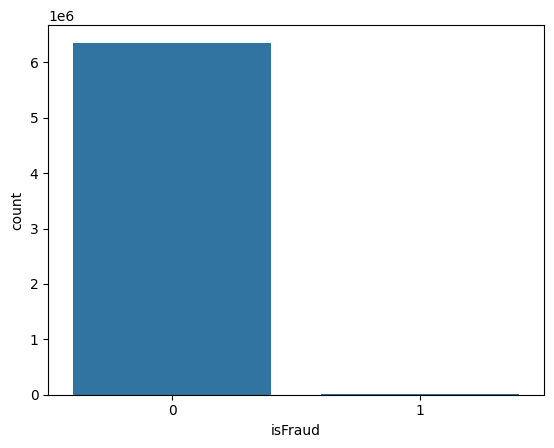

In [6]:
# Fraud

sns.countplot(x = 'isFraud',  data=dataset)
plt.show()

In [7]:
# number of actual frauds in the dataset
dataset.groupby('isFraud')['isFraud'].count()

isFraud
0    6354407
1       8213
Name: isFraud, dtype: int64

From the diagram above, it's almost impossible to see the number of fraudulent transactions due to their small value. But as we can see, 8213 compared to 6354407 is very small. It's possible that frauds happen infrequently in this dataset, and hence, the values we are seeing are accurate.

#### Flagged Fraud

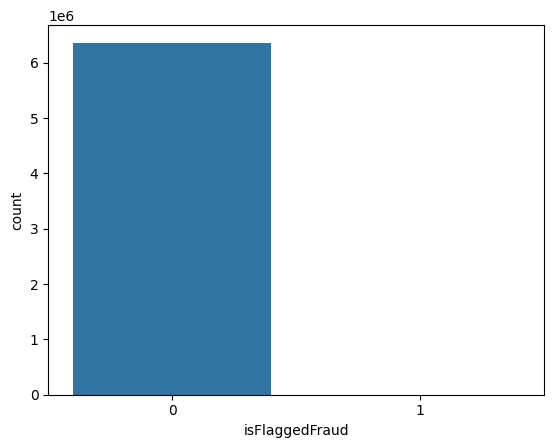

In [8]:
# successfully flagged fraud
sns.countplot(x = 'isFlaggedFraud',  data=dataset)
plt.show()

In [9]:
# number of successfully flagged frauds in the dataset
dataset.groupby('isFlaggedFraud')['isFlaggedFraud'].count()

isFlaggedFraud
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

16 frauds were detected out of 8213, which is an abysmal performance for fraud detection. That is 0.19% of the actual fraud that occurred. This is a good case for employing advanced or more competent fraud detection mechanisms for effective and efficient fraud detection.

#### Transaction Types vs Fraud

<Axes: xlabel='type', ylabel='count'>

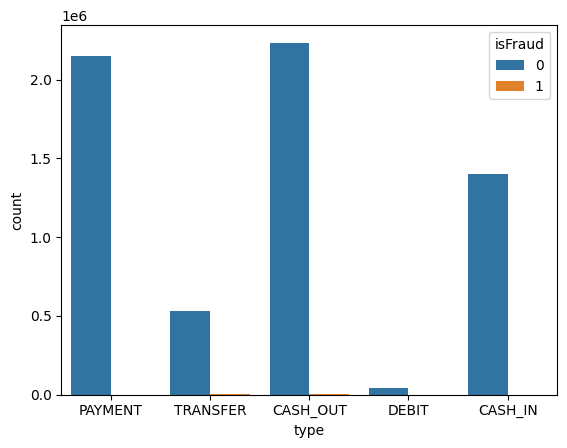

In [10]:
# Transaction Types
sns.countplot(x = 'type', hue='isFraud',  data=dataset)

In [11]:
# Get the number of fraud cases in each transaction type
dataset.groupby('type').agg(transaction_count = ('type', 'count'),
                                   isFraud =('isFraud','sum'),).reset_index()


,type,transaction_count,isFraud
0,CASH_IN,1399284,0
1,CASH_OUT,2237500,4116
2,DEBIT,41432,0
3,PAYMENT,2151495,0
4,TRANSFER,532909,4097


We can see that the **TRANSFER** and **CASH_OUT** types are mainly used to commit these fraudulent transactions. These transaction operations make sense because they involve an end-user physically withdrawing or moving money into an account of choice. Also, Fraud detection strategies should prioritise monitoring these high-risk categories.

#### Transaction Type VS Fraud VS Flagged Fraud

In [12]:
# Get the number of fraud cases and detected cases in each transaction type
sta_df = dataset.groupby('type').agg(isFraud = ('isFraud', 'sum'),
                                   isFlaggedFraud =('isFlaggedFraud','sum'),).reset_index()


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'CASH_OUT'),
  Text(2, 0, 'DEBIT'),
  Text(3, 0, 'PAYMENT'),
  Text(4, 0, 'TRANSFER')])

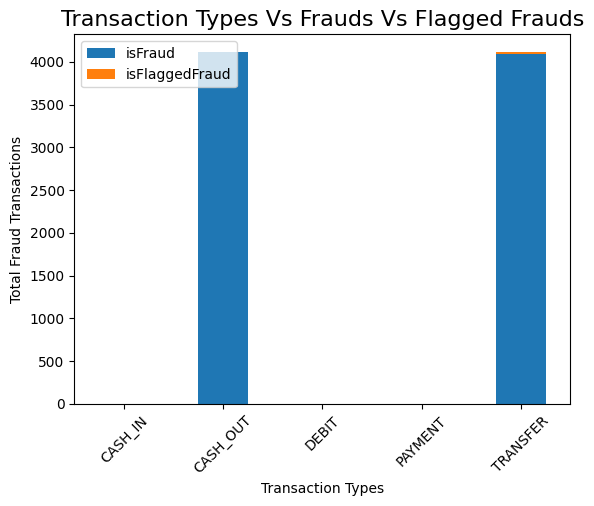

In [13]:
#create stacked bar chart for transaction_types Vs actual Fraud Vs successfully detected Fraud
sta_df.set_index('type').plot(kind='bar', stacked=True)

#add overall title
plt.title('Transaction Types Vs Frauds Vs Flagged Frauds', fontsize=16)

#add axis titles
plt.xlabel('Transaction Types')
plt.ylabel('Total Fraud Transactions')

#rotate x-axis labels
plt.xticks(rotation=45)

In [14]:
# Get the all fraud cases in each transaction type
sta_df

,type,isFraud,isFlaggedFraud
0,CASH_IN,0,0
1,CASH_OUT,4116,0
2,DEBIT,0,0
3,PAYMENT,0,0
4,TRANSFER,4097,16


The chart shows that successfully detected fraud is a small fraction of the total cases, primarily occurring in **TRANSFER**-type transactions. This is understandable, given the challenges in detecting **CASH_OUT** fraud, which involves a significant human element, especially in mobile money scenarios. Fraudsters often exploit social engineering tactics to obtain confidential information from customers, facilitating easy withdrawal initiation.
**CASH_OUT** fraud is not just difficult, but almost impossible to revert as well because, when the money is removed from the account it cannot be tracked, while **TRANSFER** is likely be detected because account to account transactions can be tracked and policies governing accounts flag these transactions easily. 

In summary fraudster prefer certain transaction types or channels (mobile money). Below I highlight the reasons my observations might be:
* Transaction types that provides a high level of anonymity.
* Transaction types that has a low scrutiny.
* Transaction that allow high amounts to be transferred.
* Transaction types that a quick which has less time to be detected.

#### Accounts Vs Fraud

Accounts usually correlate to fraud. The fraud detection system monitors and flags certain accounts based on the type of amount the account sends and receives or other factors. For example, **CASH_OUT** transaction type source accounts (**nameOrig**) can normally be the destination account for a previous **TRANSFER** type transaction.

In [15]:
# Was a CASH_OUT transaction source account(nameOrig) previously used as 
# TRANSFER transactions destination account?

actual_fraud = dataset.loc[dataset['isFraud'] == 1]
actual_fraud.head()

,step,type,amount,nameOrig,oldBalanceOrg,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [16]:
# Fraud transaction (isFraud = 1)
cash_out__fraud_tx = actual_fraud.loc[actual_fraud['type'] == 'CASH_OUT']
transfer_fraud_tx = actual_fraud.loc[actual_fraud['type'] == 'TRANSFER']

# test if there are any CASH_OUT source account in a TRANSFER transaction destination account
intersected_accounts = pd.merge(cash_out__fraud_tx, transfer_fraud_tx, how='inner', on=['nameOrig','nameDest'])
intersected_accounts

,step_x,type_x,amount_x,nameOrig,oldBalanceOrg_x,newBalanceOrig_x,nameDest,oldBalanceDest_x,newBalanceDest_x,isFraud_x,isFlaggedFraud_x,step_y,type_y,amount_y,oldBalanceOrg_y,newBalanceOrig_y,oldBalanceDest_y,newBalanceDest_y,isFraud_y,isFlaggedFraud_y


An empty result shows that no **TRANSFER** destination accounts were used as source accounts for **CASH_OUT** transactions. This might mean that the cases for **CASH_OUT** and **TRANSFER** transactions are unrelated.

#### Amount Vs Fraud

While working with **AMOUNT** I realised that the data points is quit large, takes a 26 seconds to compute and execute, also observations will be too clattered. 

Check how transactions are distributed across the types **CASH_OUT, TRANSFER, CASH_IN, DEBIT, PAYMENT**

In [17]:
# Check unique values and their counts 
# for the column 'type'
dataset['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Let’s convert these raw numbers into proportions using the normalize=True parameter.

In [18]:
# Get ratio instead of raw numbers using normalize=True
expected_ratio = dataset['type'].value_counts(normalize=True)

# Round and then convert to percentage
expected_ratio = expected_ratio.round(4)*100

# convert to a DataFrame and store in variable 'type_ratios'
# We'll use this variable to compare ratios for samples
# selected using SRS and Stratified Sampling
type_ratios = pd.DataFrame({'Expected':expected_ratio})
type_ratios

,Expected
type,
CASH_OUT,35.17
PAYMENT,33.81
CASH_IN,21.99
TRANSFER,8.38
DEBIT,0.65


Text(0.5, 1.0, 'zoomed amount vs Fraud')

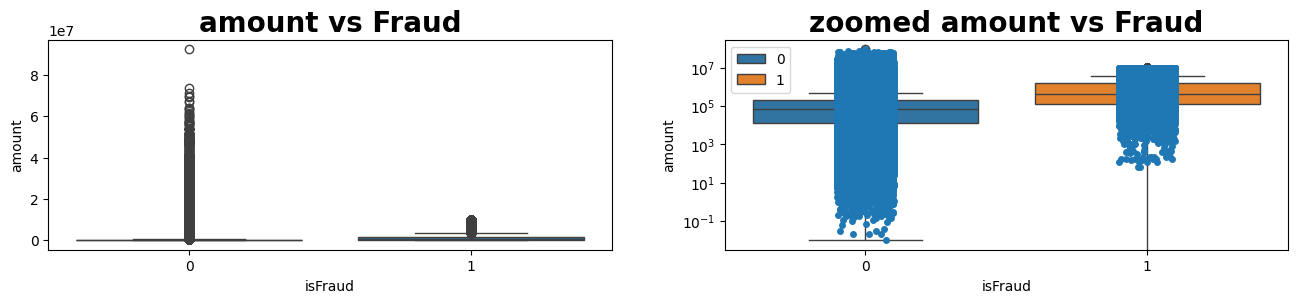

In [19]:
# Plot for amount and Fraud

plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
sns.boxplot(x= dataset.isFraud, y= dataset.amount, data=dataset)
plt.title('amount vs Fraud',fontweight="bold", size=20)


plt.subplot(2,2,2)
sns.boxplot(x= dataset.isFraud, y= dataset.amount, data = dataset, hue=dataset.isFraud)
# adding data points
sns.stripplot(x = dataset.isFraud, y = dataset.amount, data = dataset)
plt.yscale('log')
plt.title('zoomed amount vs Fraud',fontweight="bold", size=20)

Non-fraud and fraud transactions have very high amounts that appear as outliers. Customers performed a lot of transactions in the lower 75% between the mean and the min. This makes sense as the bulk of daily transactions are low amounts. For example, customers rarely buy or pay for items that are expensive on average. The same goes for fraud transactions as well, but in comparison, fraud transactions are mostly higher amounts than non-fraud transactions. 

We can see that **isFraud=1** has a higher mean than **isFraud=0**. It is strange how fraud transactions have a higher mean, hence averaging higher amounts than non-fraud transactions. This could mean fraudsters are confident enough to perform these transactions because they would not get caught, or the system for detecting these frauds is not efficient enough. 
Typically, fraudsters aim to siphon smaller amounts of transactions under the radar to avoid detection. However, our data presents an unexpected pattern.

#### Amount Vs Type Vs Fraud

This is the percentage of rows we have for each transaction type. I expect a sample from this dataset to have a similar distribution across types.

Text(0.5, 1.0, 'zoomed Amount vs Types vs Fraud')

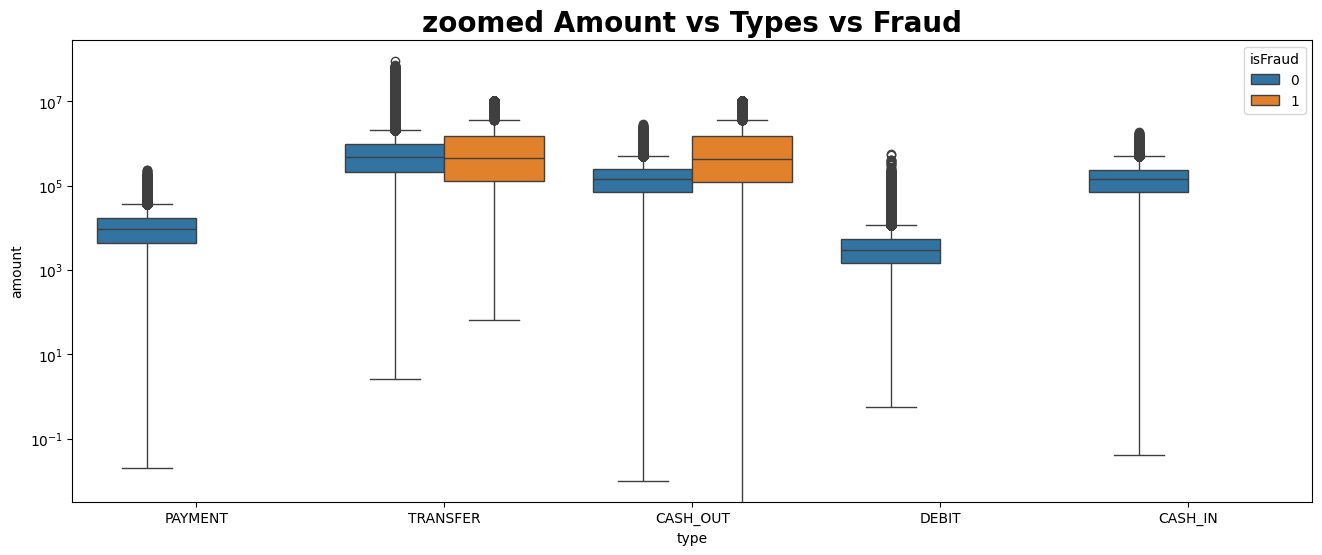

In [20]:
plt.figure(figsize=(16, 6))

sns.boxplot(hue = dataset.isFraud, x = dataset.type, y = dataset.amount, data = dataset)
plt.yscale('log')
plt.title('zoomed Amount vs Types vs Fraud',fontweight="bold", size=20)


Frauds of **TRANSFER** type have an average transaction amounts slightly less than that of a non-fraud transaction, looking at the dispersion at the mean of the two plots. While compared to transactions of **CASH_OUT** type, we can see that the average/mean fraud amount is distinctively higher than those non-fraud. This might be because fraudsters usually move small amounts of money in the system under the radar to avoid detection and then cash out big in the end. This also goes back to why there were more frauds of **CASH_OUT** type to **TRANSFER** also, not forgetting that only **TRANSFER** type fraud was successfully flagged. Hence fraudsters might do smaller amounts of transfers and bigger amount of cash outs.

Using amount a transaction amount is one of the less complex features to detect fraud. There are several strategies that can be used to identify potential fraudulent
activities. Some of these strategies are
* Using transaction thresholds, this is very effective when you know a customers spending/transaction pattern.
* Frequency analysis used to identify sudden spikes in transactions amounts.
* Large amount coming from locations inconsistent with a customers behavior.



#### BALANCE Vs FRAUD
In this section I will investigate to see if the balance before a transactions has an correlation on fraud.

Balance - Monitory transaction patterns using account balances can be used to detect fraud especially in scenarios where there is a sudden significant drop or increase in an accounts balances. This in conjunction with unusual transaction pattern inconsistent with a customer behavior can considered as a detection strategy. Customers normal have regular spending patterns.


In [21]:
# clone the dataset
df = dataset.copy()

In [22]:
# Preprocessing for correlation matrix
# Encoding categorical variables for correlation plot
# use df
le =  LabelEncoder()
df['type'] = le.fit_transform(df.type)

# Drop categorical attributes with no useful information
df_numeric = df.drop(columns=['nameOrig','nameDest'], axis=1)



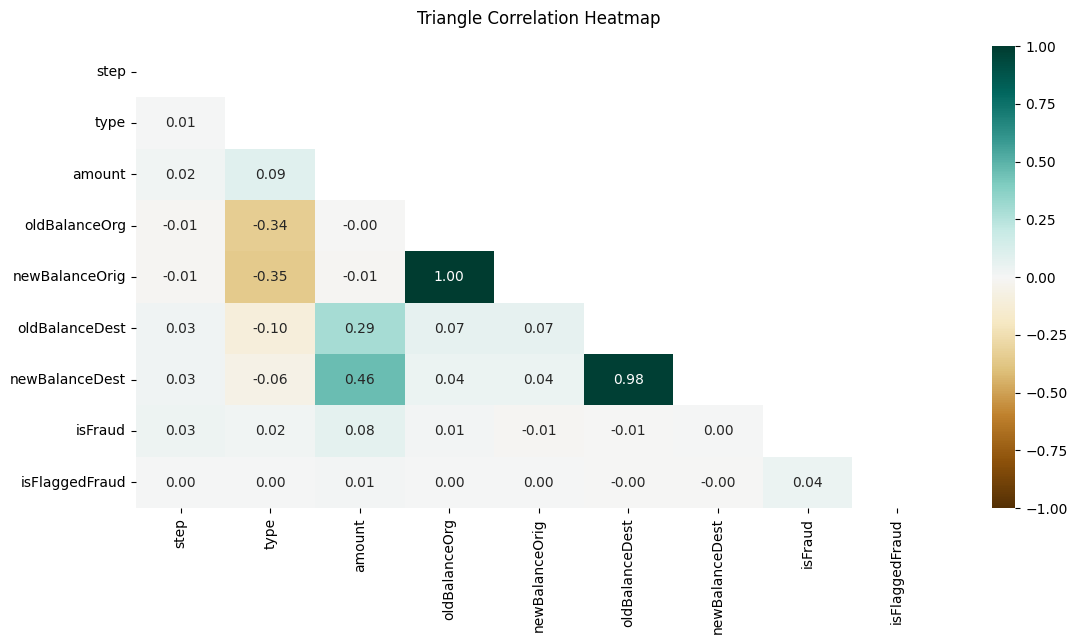

In [23]:
# Plot correlation map
plt.figure(figsize=(13, 6))

# Mask to isolate upper triangle of matrix
mask = np.triu(np.ones_like(df_numeric.corr(), dtype=np.bool))

heatmap = sns.heatmap(df_numeric.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='BrBG', mask=mask)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':12}, pad=16);

plt.show()

Looking at the diagram , Amount Vs IsFraud has an r-value of 0.08 which is not a too much correlation between the two is statistically significant and therefore the correlation is not by chance 

In [35]:
# Implementing Stratified Sampling which maintains the population group ratios
stratified_sample = df_numeric.groupby('type').apply(
    lambda x: x.sample(frac=0.20)
)
stratified_sample

step  type      amount  oldBalanceOrg  newBalanceOrig  \
type                                                                  
0    3347586   253     0   214850.52      205117.26       419967.77   
     6111815   526     0    66192.41       29929.00        96121.41   
     4745167   333     0   157706.66        3940.00       161646.66   
     6135886   544     0   107527.95     3184298.16      3291826.11   
     731872     37     0    63101.92         554.00        63655.92   
...            ...   ...         ...            ...             ...   
4    510632     20     4   885850.49           0.00            0.00   
     4609844   329     4   662480.12      140270.24            0.00   
     6010758   442     4    91422.92       12937.00            0.00   
     580342     33     4  1031949.48       10035.00            0.00   
     3271372   251     4   261775.26           0.00            0.00   

              oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
type                                                                   
0    3347586       261065.44        46214.92        0               0  
     6111815      2000076.93      1933884.51        0               0  
     4745167       173946.49        16239.83        0               0  
     6135886       554866.77       447338.82        0               0  
     731872        615342.46       552240.54        0               0  
...                      ...             ...      ...             ...  
4    510632        977441.29      1863291.78        0               0  
     4609844      6098953.95      6761434.08        0               0  
     6010758      1267483.23      1358906.16        0               0  
     580342             0.00      1031949.48        0               0  
     3271372      3734179.54      3995954.81        0               0  

[1272524 rows x 9 columns]

In [33]:
#create function to calculate p-values for each pairwise correlation coefficient
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 3)
    return p

In [36]:
r_pvalues(stratified_sample)


,step,type,amount,oldBalanceOrg,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
amount,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
isFlaggedFraud,0.0,0.001,0.0,0.006,0.007,0.523,0.512,0.0,0.0
isFraud,0.0,0.0,0.0,0.0,0.0,0.0,0.788,0.0,0.0
newBalanceDest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788,0.512
newBalanceOrig,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007
oldBalanceDest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.523
oldBalanceOrg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006
step,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
type,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001
